# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных 

### Технологический процесс  

- *Rougher feed* — исходное сырье;
- *Rougher additions* (или *reagent additions*) — флотационные реагенты: Xanthate, Sulphate, Depressant;
- *Xanthate* — ксантогенат (промотер, или активатор флотации);
- *Sulphate* — сульфат (на данном производстве сульфид натрия);
- *Depressant* — депрессант (силикат натрия).
- *Rougher process* (англ. «грубый процесс») — флотация;
- *Rougher tails* — отвальные хвосты;
- *Float banks* — флотационная установка;
- *Cleaner process* — очистка;
- *Rougher Au* — черновой концентрат золота;
- *Final Au* — финальный концентрат золота;  

#### Параметры этапов: 

- *air amount* — объём воздуха;
- *fluid levels* — уровень жидкости;
- *feed size* — размер гранул сырья;
- *feed rate* — скорость подачи;

#### Возможные значения для блока `этап`: 

- *rougher* — флотация;
- *primary_cleaner* — первичная очистка;
- *secondary_cleaner* — вторичная очистка;
- *final* — финальные характеристики;  

#### Возможные значения для блока `тип_параметра`:  

- *input* — параметры сырья;
- *output* — параметры продукта;
- *state* — параметры, характеризующие текущее состояние этапа;
- *calculation* — расчётные характеристики.


## Оглавление

- [1. Подготовка данных](#id-1)
    - [1.1 Знакомство с данными](#id-1.1)
    - [1.2 Расчет эффективности обогащения золотом](#id-1.2)
    - [1.3 Анализ признаков, недоступных в тестовой выборке](#id-1.3)
    - [1.4 Предобработка данных](#id-1.4)
- [2. Анализ данных](#id-2)
    - [2.1. Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#id-2.1)
    - [2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#id-2.2)
    - [2.3. Исследование суммарной концентрации всех веществ на разных стадиях](#id-2.3)
- [3. Модель](#id-3)
    - [3.1 Отделение целевых признаков. Написание функций расчета  sMAPE](#id-3.1)
    - [3.2 Поиск оптимальных гиперпараметров](#id-3.2)
    - [3.3 Обучение моделей. Расчет итогового SMAPE](#id-3.3)
    - [3.4 Проверка модели на адекватность](#id-3.4)
- [Общий вывод](#id-4)


<div id='id-1'/>

# 1. Подготовка данных

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import warnings


from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor 

%matplotlib inline

Отключим предупреждения:

In [60]:
warnings.filterwarnings("ignore")

<div id='id-1.1'/>

### 1.1 Знакомство с данными

Загрузим датасеты и посмотрим на данные с помощью методов **.info(), .describe()** и **.head()**.  

Чтобы было удобнее, тренировочные и тестовые данные объединим в список **dfs**.

In [61]:
try:
    train_data = pd.read_csv('gold_recovery_train.csv')
    test_data = pd.read_csv('gold_recovery_test.csv')
    full_data = pd.read_csv('gold_recovery_full.csv')
except:
    train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
    test_data = pd.read_csv('/datasets/gold_recovery_test.csv')
    full_data = pd.read_csv('/datasets/gold_recovery_full.csv')
    
dfs = [train_data, test_data]

In [62]:
for df in dfs:
    display(df.head(10))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


In [63]:
for df in dfs:
    display(df.describe())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [64]:
for df in dfs:
    
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

Единственный признак, в котором надо будет поменять тип данных - это *date*. Сделаем это на этапе предобработки данных.  

Проверим, есть ли дубликаты:

In [65]:
for df in dfs:
    display(df.duplicated().sum())

0

0

Дублирующихся значений в наших данных нет.  

Теперь посмотрим на количество пропусков в датасетах (в процентах):

In [66]:
for df in dfs:
    display((df.isna().mean() * 100).sort_values(ascending=False).head(15))

rougher.output.recovery                   15.260973
rougher.output.tail_ag                    13.345196
rougher.output.tail_sol                   13.339265
rougher.output.tail_au                    13.339265
secondary_cleaner.output.tail_sol         11.779359
rougher.input.floatbank11_xanthate        11.293001
final.output.recovery                      9.021352
primary_cleaner.input.sulfate              7.752076
primary_cleaner.input.depressant           7.485172
rougher.calculation.au_pb_ratio            7.366548
rougher.input.floatbank10_sulfate          6.192171
primary_cleaner.input.xanthate             5.842230
primary_cleaner.output.concentrate_sol     3.772242
rougher.input.floatbank11_sulfate          3.695136
rougher.state.floatbank10_e_air            3.576512
dtype: float64

rougher.input.floatbank11_xanthate          6.028005
primary_cleaner.input.sulfate               5.157104
primary_cleaner.input.depressant            4.849727
rougher.input.floatbank10_sulfate           4.388661
primary_cleaner.input.xanthate              2.834699
rougher.input.floatbank10_xanthate          2.100410
rougher.input.feed_sol                      1.144126
rougher.input.floatbank11_sulfate           0.939208
rougher.input.feed_rate                     0.683060
secondary_cleaner.state.floatbank3_a_air    0.580601
secondary_cleaner.state.floatbank2_b_air    0.392760
rougher.input.feed_size                     0.375683
secondary_cleaner.state.floatbank2_a_air    0.341530
rougher.state.floatbank10_e_air             0.290301
rougher.state.floatbank10_d_air             0.290301
dtype: float64

Как видно, в датасетах довольно много пропусков, особенно в `train_data`: в целевом признаке *rougher.output.recovery* отсутствует 15.26% значений, в *final.output.recovery* - 9.02% значений.   

В тестовом датасете пропусков меньше, максимум 6.03% в признаке *rougher.input.floatbank11_xanthate*, однако, в нем вообще нет целевых признаков. Разберемся с этим, как и с пропусками, позже.  

<div id='id-1.2'/>

### 1.2 Расчет эффективности обогащения золотом  

Посчитаем вручную эффективность обогащения золотом и посмотрим на метрику **MAE** между нашими расчетами и *rougher.output.recovery*:

In [67]:
concentrate = train_data['rougher.output.concentrate_au'] 
feed = train_data['rougher.input.feed_au']
tail = train_data['rougher.output.tail_au']
train_data['rougher.output.recovery.calculated'] = (concentrate * (feed - tail)) / (feed * (concentrate - tail)) * 100
mae = (sum(abs(train_data['rougher.output.recovery.calculated'] - 
              train_data['rougher.output.recovery'])) / train_data.shape[0])
print(mae)

nan


Учитывая, что пропуски никуда не делись, мы логично получили в результате `nan`. Сделаем копию датасета, удалим оттуда пропуски и попробуем еще раз.

In [68]:
train_copy = train_data.copy()
train_copy = train_copy.dropna()

In [69]:
mae_2 = mean_absolute_error(train_copy['rougher.output.recovery.calculated'], train_copy['rougher.output.recovery'])
print(mae_2)

9.555596961987514e-15


Полученное значение MAE очень низкое (9.555596961987514e-15), соответственно, эффективность обогащения рассчитана правильно.  

<div id='id-1.3'/>

### 1.3 Анализ признаков, недоступных в тестовой выборке

Чтобы найти признаки, которых нет в тестовой выборке, создадим списки из названий признаков обучающей и тестовой выборок, а затем найдем те их них, которые есть только в обучающей.

In [70]:
train_features = train_data.columns.tolist()
test_features = test_data.columns.tolist()  
unique_features = []
for feature in train_features:
    if feature not in test_features:
        unique_features.append(feature)
display(unique_features) 
print(f'Количество признаков, недоступных в тестовой выборке: {len(unique_features)}')

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Количество признаков, недоступных в тестовой выборке: 35


Как видно, в тестовой выборке нет признаков типов **output** - параметры продукта и **calculation** - расчётные характеристики. Из условий проекта известно, что некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже - видимо, это как раз тот случай.  

Кроме того, может быть указанием на то, на каких данных должна обучаться модель: если ей дать на вход параметры продукта после очистки и расчётные характеристики, результат может получиться смещенным. Поэтому модель мы будем обучать на первичных данных **(rougher.input** и **rougher.state)**, так как все остальные данные не могут быть известны до начала работы с рудой, соответственно, для обучения модели не будет хватать данных, если оставить все признаки, которые есть в выборках изначально. Возможно, мы получим больше информации в процессе анализа данных.

<div id='id-1.4'/>

### 1.4 Предобработка данных  

На этом этапе нам понадобятся все датасеты: нужно будет дополнить тестовую выборку данными из `full_data`. Поэтому соберем все данные в один список:

In [71]:
all_dfs = [train_data, test_data, full_data]

Ранее мы уже смотрели на обучающую и тестовую выборки, поэтому сейчас немного познакомимся с полными данными.

In [72]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [73]:
(full_data.isna().mean() * 100).sort_values(ascending=False).head(15)

rougher.output.recovery                   13.730410
rougher.output.tail_ag                    12.048776
rougher.output.tail_sol                   12.044374
rougher.output.tail_au                    12.044374
rougher.input.floatbank11_xanthate         9.935728
secondary_cleaner.output.tail_sol          9.750836
final.output.recovery                      8.641486
rougher.calculation.au_pb_ratio            7.162353
primary_cleaner.input.sulfate              7.083113
primary_cleaner.input.depressant           6.805776
rougher.input.floatbank10_sulfate          5.727241
primary_cleaner.input.xanthate             5.066913
primary_cleaner.output.concentrate_sol     3.512942
rougher.input.floatbank11_sulfate          2.984680
rougher.state.floatbank10_e_air            2.729354
dtype: float64

Пропусков тут все так же много. Это неудивительно, потому что все данные для тестовой и обучающей выборок получены именно из этой таблицы. Тем не менее, мы сможем добавить из нее целевые признаки в тестовую выборку.  

Начнем с изменения типа данных в признаке `date` на **datetime**.

In [74]:
for df in all_dfs:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

Добавим в тестовую выборку целевые признаки и посмотрим на количество пропусков в обновленной выборке:

In [75]:
test_data = test_data.merge(full_data[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')

In [76]:
(test_data.isna().mean() * 100).sort_values(ascending=False)

rougher.output.recovery                       9.323770
final.output.recovery                         7.547814
rougher.input.floatbank11_xanthate            6.028005
primary_cleaner.input.sulfate                 5.157104
primary_cleaner.input.depressant              4.849727
rougher.input.floatbank10_sulfate             4.388661
primary_cleaner.input.xanthate                2.834699
rougher.input.floatbank10_xanthate            2.100410
rougher.input.feed_sol                        1.144126
rougher.input.floatbank11_sulfate             0.939208
rougher.input.feed_rate                       0.683060
secondary_cleaner.state.floatbank3_a_air      0.580601
secondary_cleaner.state.floatbank2_b_air      0.392760
rougher.input.feed_size                       0.375683
secondary_cleaner.state.floatbank2_a_air      0.341530
rougher.state.floatbank10_f_air               0.290301
rougher.state.floatbank10_a_air               0.290301
rougher.state.floatbank10_b_air               0.290301
rougher.st

Мы не можем достоверно определить, почему возникли пропуски в данных - возможно, были ошибки при выгрузке или же данных изначально не хватало.  

Однако, в условиях задачи указано, что данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.   

Это дает нам стратегию заполнения пропусков - будем ориентироваться на похожее время. Однако, пропуски в целевых признаках просто удалим - их заполнять не требуется, так как эти значения мы должны предсказывать.

In [77]:
train_data = train_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
test_data = test_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
full_data = full_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

In [78]:
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')
full_data = full_data.fillna(method='ffill')

In [79]:
display(train_data.isna().any().sum())
display(test_data.isna().any().sum())
display(full_data.isna().any().sum())

0

0

0

#### Вывод 

1. Мы убедились, что эффективность обогащения рассчитана правильно: **MAE** между нашими расчётами и значением признака составила 9.555596961987514e-15.
2. В тестовой выборке нет признаков типов **output** - параметры продукта и **calculation** - расчётные характеристики: логично, что мы не можем их знать изначально, поэтому модель ими кормить не нужно. 
3. В рамках предобработки данных мы провели работу с пропусками и изменили тип признака `date` на **datetime**.

In [80]:
test_data.shape, train_data.shape

((5290, 55), (14149, 88))

<div id='id-2'/>

# 2. Анализ данных

<div id='id-2.1'/>

### 2.1. Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки  

Используя графики, сравним, как меняется концентрация различных металлов на каждом этапе очистки.  

Создадим функцию для построения графиков:

In [81]:
#Настроим параметры графиков
sns.set(rc={"figure.figsize": (15, 8)})
sns.set_style("whitegrid")

In [82]:
def plots(elem_list, elem):
    '''Функция создает гистограмму плотности распределения и боксплот концентрации 
    заданного элемента на разных стадиях очистки руды.
    Функция принимает на вход аргументы:
    elem_list - список признаков
    elem - название элемента.
    '''
    
    for col in elem_list:
        sns.distplot(full_data[col], label=col)
    plt.xlabel('Concentration')
    plt.ylabel('Density')
    plt.title(f'Изменение концентрации {elem} на различных стадиях')
    plt.legend()
    plt.show()
    
    my_order = full_data[elem_list].median().sort_values().index
    
    sns.boxplot(data=full_data[elem_list], order=my_order, palette='cubehelix_r')
    plt.ylabel('Concentration')
    plt.title(f'Изменение концентрации {elem} на различных стадиях')
    plt.show()

<center><b>Золото (Aurum)</b></center>  


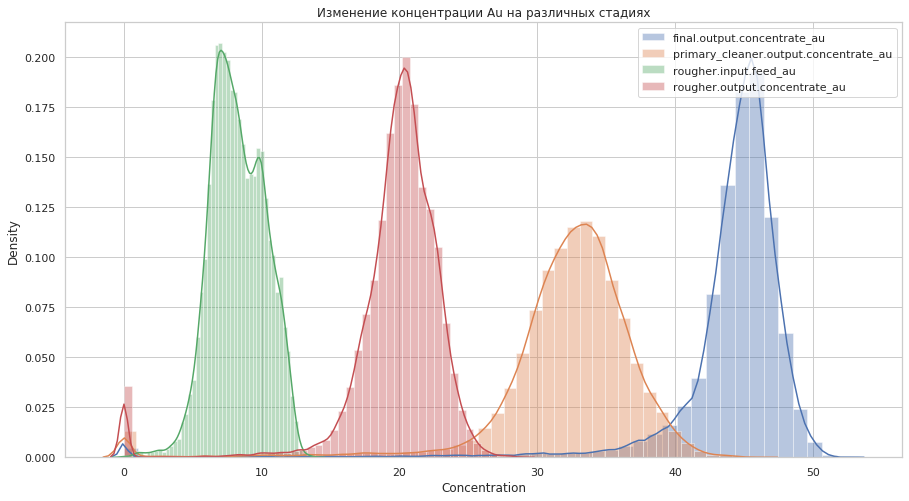

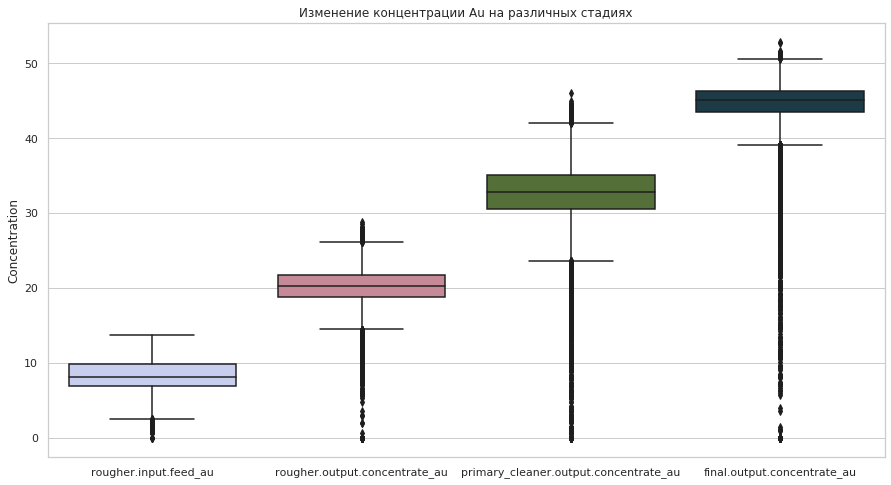

In [83]:
au_concentrate = []
for col in full_data.columns:
    if 'output.concentrate_au' in col or 'rougher.input.feed_au' in col:
        au_concentrate.append(col)

plots(au_concentrate, 'Au')

Посмотрим на то, как растет концентрация золота в процессе очищения руды:

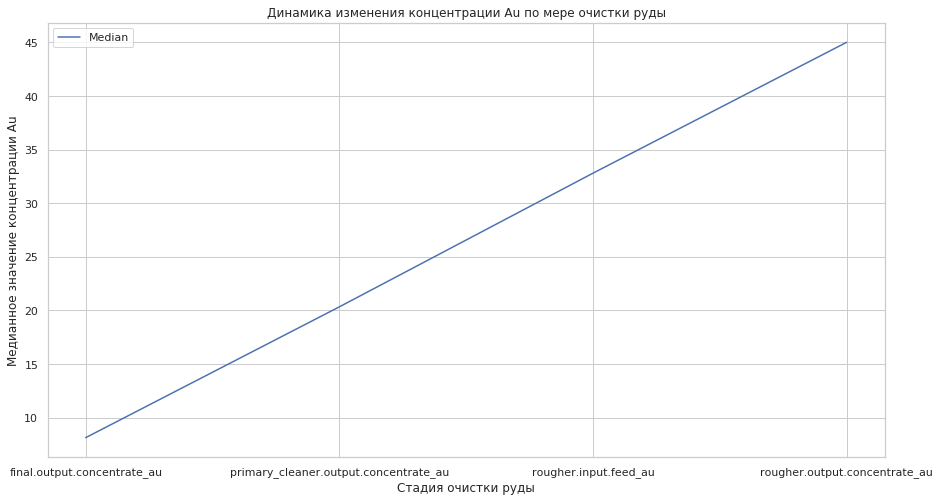

In [1957]:
data_au = full_data[au_concentrate].median().sort_values()
sns.lineplot(x=au_concentrate, y=data_au, label='Median')
plt.xlabel('Стадия очистки руды')
plt.ylabel('Медианное значение концентрации Au')
plt.title('Динамика изменения концентрации Au по мере очистки руды')
plt.legend()
plt.show()

Очевидно, что концентрация золота увеличивается линейно по мере очищения руды. На всех этапах присутствуют выбросы.  

Линейноность увеличения концентрации золота подтверждает, что для обучения модели достаточно будет оставить данные только о концентрации золота в сырье.

<center><b>Серебро (Argentum)</b></center>  


Посмотрим на то, как изменяется концентрация серебра (Argentum):

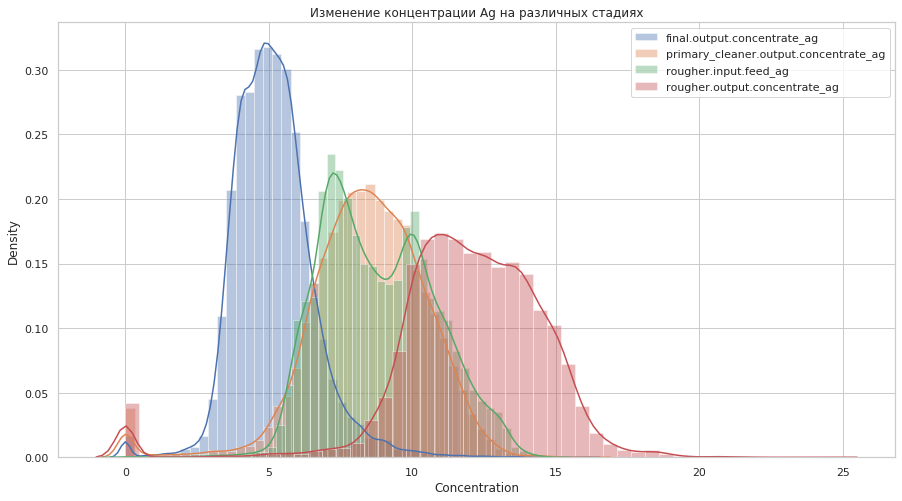

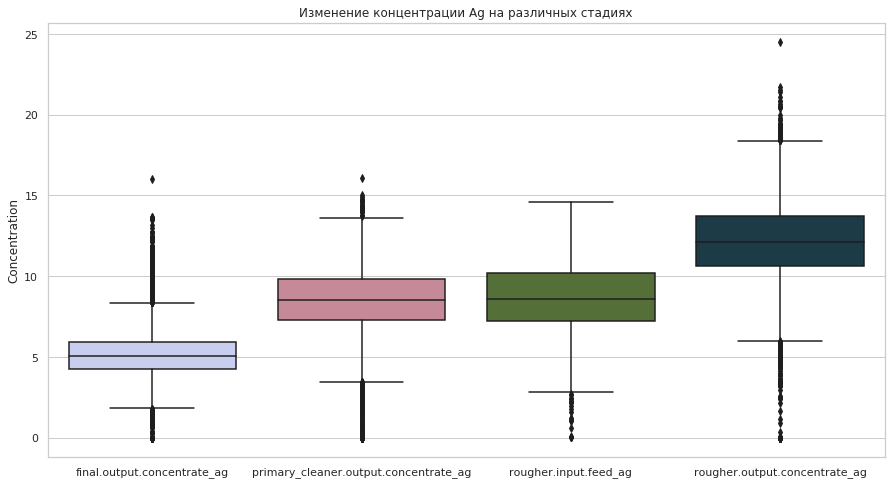

In [85]:
ag_concentrate = []
for col in full_data.columns:
    if 'output.concentrate_ag' in col or 'rougher.input.feed_ag' in col:
        ag_concentrate.append(col)

plots(ag_concentrate, 'Ag')

Максимальная концентрация серебра в руде наблюдается после флотации, а дальше начинает снижаться. Минимальное количество серебра в руде достигается после второго этапа очистки. На графиках отчетливо видно, что в данных есть выбросы.  



<center><b>Свинец (Plumbum)</b></center>  

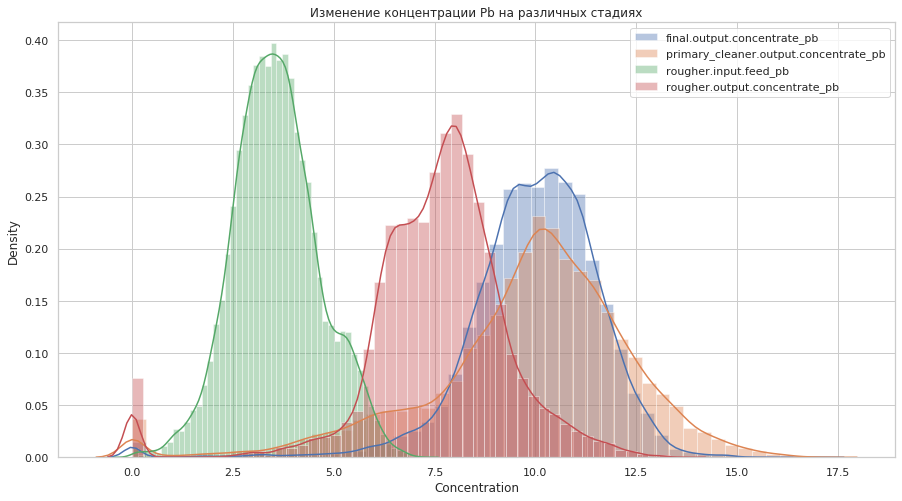

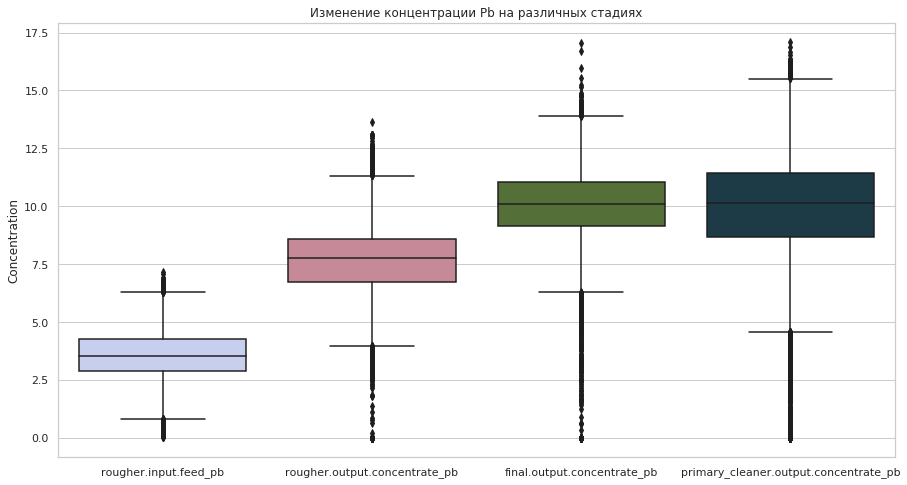

In [86]:
pb_concentrate = []
for col in full_data.columns:
    if 'output.concentrate_pb' in col or 'rougher.input.feed_pb' in col:
        pb_concentrate.append(col)

plots(pb_concentrate, 'Pb')

Концентрация свинца повышается в процессе очистки руды. На финальной стадии разброс значений концентрации снижается - они распределяются вокруг медианного значения. Так же, как и в остальных случаях, на всех этапах есть выбросы.

<div id='id-2.2'/>

### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Визуализируем распределение размеров гранул сырья на обучающей и тестовой выборках до очистки руды и после первичной очистки:

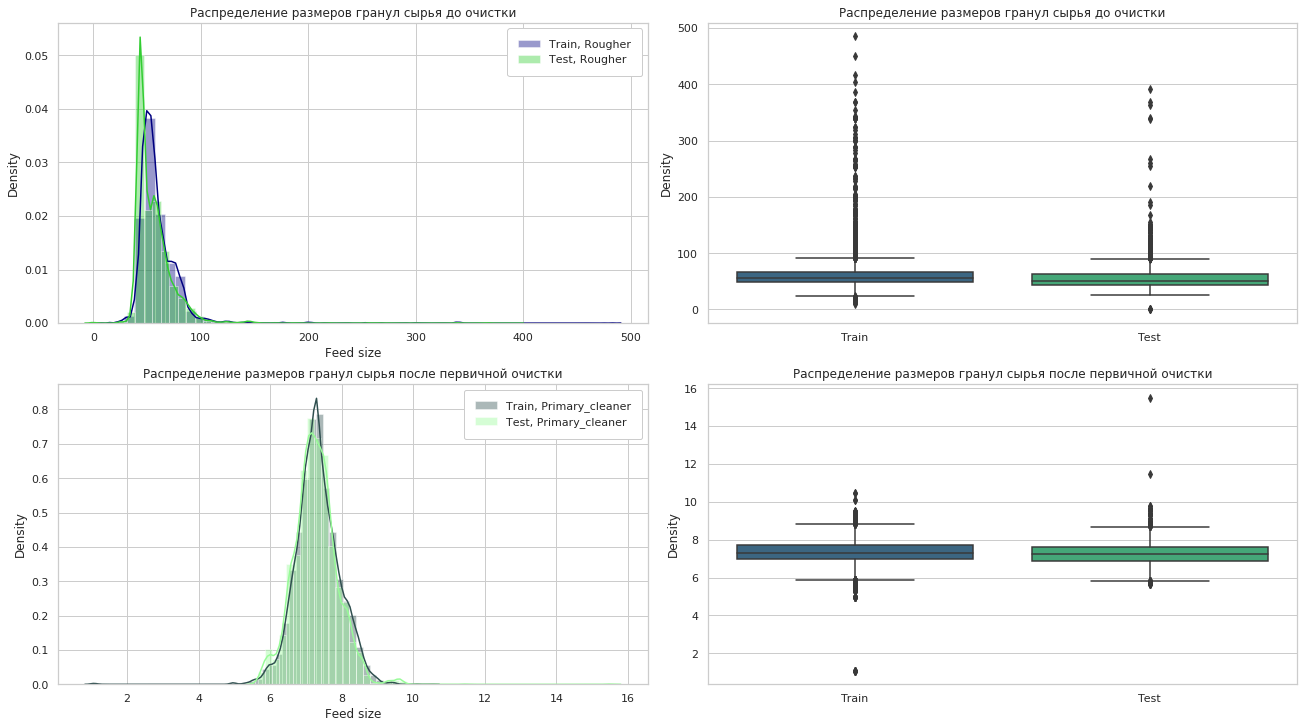

In [87]:
#обновим параметры отображения для графиков
sns.set(rc={"figure.figsize": (18, 10)})
sns.set_style("whitegrid")

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 4)

f_ax1 = fig.add_subplot(gs[0:3, :2])
sns.distplot(train_data['rougher.input.feed_size'], color='navy', label='Train, Rougher', ax=f_ax1)
sns.distplot(test_data['rougher.input.feed_size'], color='limegreen', label='Test, Rougher', ax=f_ax1)
f_ax1.set_title('Распределение размеров гранул сырья до очистки')
f_ax1.set_xlabel('Feed size')
f_ax1.set_ylabel('Density')
f_ax1.legend(fancybox=True, framealpha=1, borderpad=1)


f_ax2 = fig.add_subplot(gs[3:, :2])
sns.distplot(train_data['primary_cleaner.input.feed_size'], color='darkslategray', label='Train, Primary_cleaner', ax=f_ax2)
sns.distplot(test_data['primary_cleaner.input.feed_size'], color='palegreen', label='Test, Primary_cleaner', ax=f_ax2)
f_ax2.set_title('Распределение размеров гранул сырья после первичной очистки')
f_ax2.set_xlabel('Feed size')
f_ax2.set_ylabel('Density')
f_ax2.legend(fancybox=True, framealpha=1, borderpad=1)


f_ax3 = fig.add_subplot(gs[0:3, 2:])
sns.boxplot(data=[train_data['rougher.input.feed_size'], test_data['rougher.input.feed_size']], palette='viridis', ax=f_ax3)
f_ax3.set_title('Распределение размеров гранул сырья до очистки')
f_ax3.set_ylabel('Density')
f_ax3.set_xticklabels(['Train', 'Test'])


f_ax4 = fig.add_subplot(gs[3:, 2:])
(sns.boxplot(data=[train_data['primary_cleaner.input.feed_size'], 
                   test_data['primary_cleaner.input.feed_size']], palette='viridis', ax=f_ax4))
f_ax4.set_title('Распределение размеров гранул сырья после первичной очистки')
f_ax4.set_ylabel('Density')
f_ax4.set_xticklabels(['Train', 'Test'])

plt.show()

Мы видим, что до очистки распределение размеров гранул сырья немного отличается: на обучающей выборке хвост сильно уходит вправо, хотя медианы почти равны, и большая часть наблюдений довольно сильно сконцентрирована вокруг них.  

После первичной очистки и на обучающей, и на тестовой выборках распределение близко к нормальному, медианы различаются совсем незначительно. Выбросов после очистки стало намного меньше.  

В принципе, отличий в распределениях достаточно мало, поэтому можно ожидать, что оценка модели будет адекватной.

<div id='id-2.3'/>

### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях

В этом пункте нужно исследовать суммарную концентрацию в сырье, в черновом и финальном концентратах.   
Начнем с добавления в таблицу `full_data` данных о суммарной концентрации золота, серебра и свинца:

In [88]:
full_data['rougher.input.feed'] = (full_data['rougher.input.feed_au'] + 
                                   full_data['rougher.input.feed_ag'] + full_data['rougher.input.feed_pb'])
full_data['rougher.output.concentrate'] = (full_data['rougher.output.concentrate_au'] + 
                                   full_data['rougher.output.concentrate_ag'] + full_data['rougher.output.concentrate_pb'])
full_data['final.output.concentrate'] = (full_data['final.output.concentrate_au'] + 
                                   full_data['final.output.concentrate_ag'] + full_data['final.output.concentrate_pb'])


Выделим эти данные в отдельную таблицу:

In [89]:
concentrations = full_data.loc[:, 'rougher.input.feed':'final.output.concentrate']

Изучим основные статистики с помощью метода **.describe()** и визуализации:

In [90]:
concentrations.describe()

,rougher.input.feed,rougher.output.concentrate,final.output.concentrate
count,19439.000000,19439.000000,19439.000000
mean,20.646120,39.373032,59.223721
std,4.480027,6.863389,6.095138
min,0.030000,0.000000,0.000000
25%,17.252879,38.394639,59.298323
50%,20.141216,40.312648,60.306921
75%,23.797381,42.365102,61.096667
max,33.498784,55.568687,64.968881


In [91]:
#Обновим параметры отображения
sns.set(rc={"figure.figsize": (15, 8)})
sns.set_style("whitegrid")

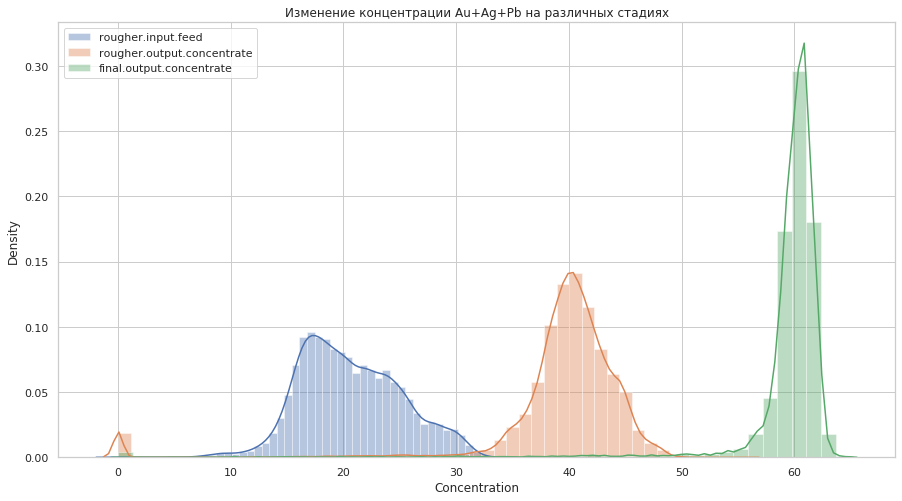

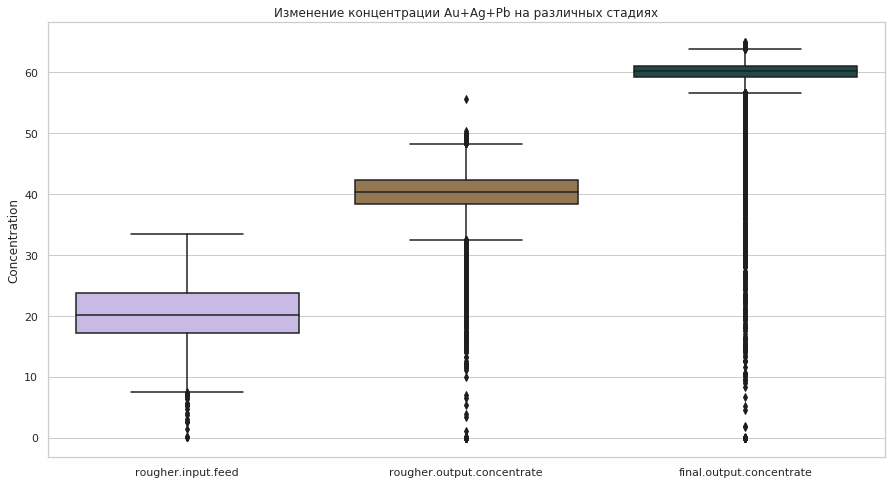

In [92]:
plots(concentrations.columns, 'Au+Ag+Pb')

Очевидно, что по мере очищения руды суммарная концентрация веществ в ней увеличивается. Мы видим, что значения распределяются вокруг медианы, все ближе к ней с каждой стадией.  

На каждом этапе наблюдаются выбросы. У признака `rougher.input.feed` минимальное значение 0.03, поэтому мы удалим во избежание получения смещенных оценок все значения, которые меньше 1.

Удалим выбросы из `concentrations` и посмотрим на обновленные распределения:

In [93]:
concentrations = (concentrations.drop(concentrations[(concentrations['rougher.input.feed'] < 1) | 
                                            (concentrations['rougher.output.concentrate'] < 1) |
                                            (concentrations['final.output.concentrate'] < 1)].index))

In [94]:
concentrations.describe()

,rougher.input.feed,rougher.output.concentrate,final.output.concentrate
count,18943.000000,18943.000000,18943.000000
mean,20.634535,40.197351,59.518061
std,4.459412,3.835304,4.351765
min,2.560855,1.137053,1.685441
25%,17.221667,38.524698,59.303801
50%,20.122762,40.369990,60.300698
75%,23.791228,42.408606,61.087050
max,33.498784,55.568687,64.968881


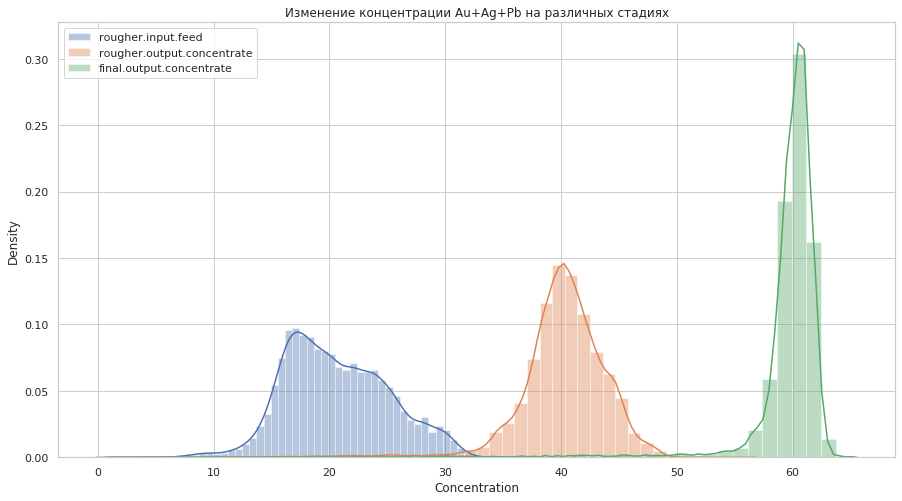

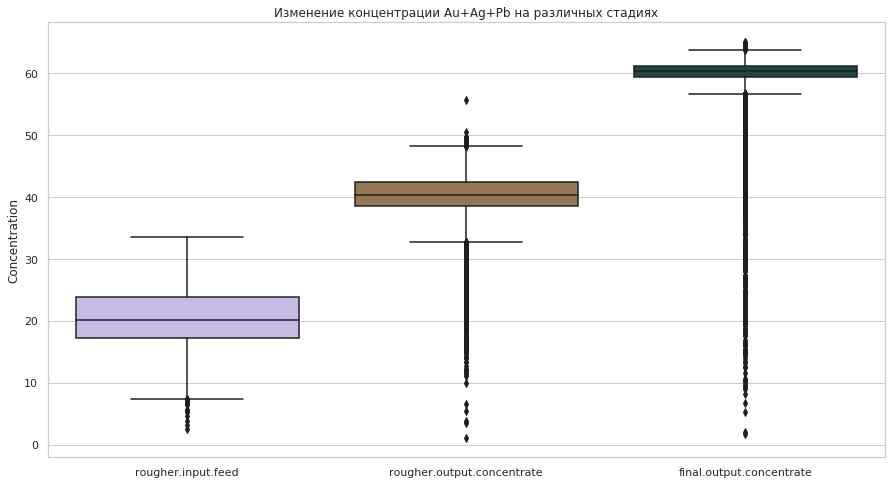

In [1958]:
plots(concentrations.columns, 'Au+Ag+Pb')

Выбросов больше нет, но нужно теперь их удалить из всех остальных таблиц, чтобы снизить вероятность того, что модель некорректно обучится. Так как индексы в датасетах могут не совпадать, будем ориентироваться на признак `date`, чтобы оставить только те строки, где значения суммарной концентрации веществ не являются выбросами.

In [96]:
full_data = (full_data.drop(full_data[(full_data['rougher.input.feed'] < 1) | 
                                            (full_data['rougher.output.concentrate'] < 1) |
                                            (full_data['final.output.concentrate'] < 1)].index))

In [97]:
train_data = train_data[train_data['date'].isin(full_data['date'])]
test_data = test_data[test_data['date'].isin(full_data['date'])]

### Вывод

1. Концентрация золота в руде в процессе очистки повышается линейно;
2. Распределения размеров гранул сырья на обучающей и тестовой выборках отличаются незначительно, значит, модель будет давать довольно точные оценки;
3. В данных о концентрации веществ были выбросы, которые мы удалили, чтобы они не смещали оценки модели.

<div id='id-3'/>

# 3. Модель  

<div id='id-3.1'/>

### 3.1  Отделение целевых признаков. Написание функций расчета  sMAPE

Вернемся к отбору признаков для обучения модели. Нужно отделить признаки от целевых переменных. Мы уже решили, что для обучения модели будут использоваться только те признаки, которые могут быть известны до начала обработки руды - **(rougher.input** и **rougher.state)**.

In [98]:
selected_columns = []
for col in train_data.columns:
    if 'rougher.state' in col or 'rougher.input' in col:
        selected_columns.append(col)

Отделим целевые признаки:

In [99]:
X_train = train_data[selected_columns]
X_test = test_data[selected_columns]
y_train_rougher = train_data['rougher.output.recovery']
y_train_final = train_data['final.output.recovery']
y_test_rougher = test_data['rougher.output.recovery']
y_test_final = test_data['final.output.recovery']

In [123]:
X_train.shape, X_test.shape

((13789, 22), (5154, 22))

Напишем функции `smape` и  `smape_final` для расчета итогового sMAPE. 

In [1959]:
def smape(y_true, y_pred):
    smape = sum(abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)) * 100 / len(y_true)
    return smape


def smape_final(smape_r, smape_f):
    '''Функция рассчитывает итоговое sMAPE.
        Функция принимает на вход аргументы:
        smape_r - sMAPE(rougher)
        smape_f - sMAPE(final)
    '''
    
    smape_final = 0.25 * smape_r + 0.75 * smape_f
    return smape_final


<div id='id-3.2'/>

### 3.2 Поиск оптимальных гиперпараметров

Мы собираемся обучать пять моделей, и чтобы автоматизировать этот процесс, напишем класс `MyRegressor`.

In [1962]:
class MyRegressor(BaseEstimator):

    def __init__(self, regressor_type: str = 'SGDRegressor'):
        
        '''Класс собирает модели, которые мы будем обучать, задает для них методы set_params, fit и predict, 
        а также метод score, возвращающий sMAPE.
        '''
        self.regressor_type = regressor_type
        
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        

    def fit(self, X, y):
        if self.regressor_type == 'SGDRegressor':
            self.regressor_ = SGDRegressor(random_state=42)
        elif self.regressor_type == 'RandomForestRegressor':
            self.regressor_ = RandomForestRegressor(random_state=42)
        elif self.regressor_type == 'LinearRegression':
            self.regressor_ = LinearRegression()
        elif self.regressor_type == 'LGBMRegressor':
            self.regressor_ = LGBMRegressor(random_state=42)
        elif self.regressor_type == 'XGBRegressor':
            self.regressor_ = XGBRegressor(random_state=42)
        else:
            raise ValueError('Unknown regressor type.')

        self.regressor_.fit(X, y)
        return self

    def predict(self, X):
        return self.regressor_.predict(X)
      
      
    def score(self, X, y):
        #По умолчанию выбирается score -> max, но мы вычисляем ошибку, поэтому нужно score -> min. 
        #Для этого сделаем sMAPE отрицательным.
        smape = -(sum(abs(y - self.predict(X)) / ((abs(y) + abs(self.predict(X))) / 2)) * 100 / len(y))    
        return smape

Создадим объект `Pipeline` для автоматизации выбора модели и обучим его на обучающей выборке для целевого признака `rougher.output.recovery`.

In [1963]:
pipe = Pipeline([('scaler', StandardScaler()), ('MyRegressor', MyRegressor())])
pipe.fit(X_train, y_train_rougher)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('MyRegressor', MyRegressor(regressor_type='SGDRegressor'))],
         verbose=False)

Создадим список словарей с параметрами для выбора лучшей модели. Для поиска оптимальных гиперпараметров будем использовать RandomizedSearchCV.

In [1964]:
params_list = [
    {
    'MyRegressor__regressor_type': ['SGDRegressor'],
    'MyRegressor__regressor_type__SGDRegressor__alpha': [10 ** x for x in range(-6, 1)],
    'MyRegressor__regressor_type__SGDRegressor__loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'MyRegressor__regressor_type__SGDRegressor__penalty': ['l2', 'l1', 'elasticnet'],
    'MyRegressor__regressor_type__SGDRegressor__learning_rate': ['constant', 'optimal', 'invscaling']
    }, {
    
    'MyRegressor__regressor_type': ['RandomForestRegressor'],
    'MyRegressor__regressor_type__RandomForestRegressor__bootstrap': [True, False],
    'MyRegressor__regressor_type__RandomForestRegressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'MyRegressor__regressor_type__RandomForestRegressor__max_features': ['auto', 'sqrt'],
    'MyRegressor__regressor_type__RandomForestRegressor__min_samples_leaf': [1, 2, 4],
    'MyRegressor__regressor_type__RandomForestRegressor__min_samples_split': [2, 5, 10],
    'MyRegressor__regressor_type__RandomForestRegressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }, {
    'MyRegressor__regressor_type': ['LinearRegression'],
    'MyRegressor__regressor_type__LinearRegression__alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, {
    'MyRegressor__regressor_type': ['LGBMRegressor'],
    'MyRegressor__regressor_type__LGBMRegressor__num_leaves': [7, 14, 21, 28, 31, 50],
    'MyRegressor__regressor_type__LGBMRegressor__learning_rate': [0.1, 0.03, 0.003],
    'MyRegressor__regressor_type__LGBMRegressor__max_depth': [-1, 3, 5],
    'MyRegressor__regressor_type__LGBMRegressor__n_estimators': [50, 100, 200, 500]    
    }, {
    'MyRegressor__regressor_type__regressor_type': ['XGBRegressor'],
    'MyRegressor__regressor_type__XGBRegressor__nthread':[4], 
    'MyRegressor__regressor_type__XGBRegressor__objective':['reg:linear'],
    'MyRegressor__regressor_type__XGBRegressor__learning_rate': [.03, 0.05, .07], 
    'MyRegressor__regressor_type__XGBRegressor__max_depth': [5, 6, 7],
    'MyRegressor__regressor_type__XGBRegressor__min_child_weight': [4],
    'MyRegressor__regressor_type__XGBRegressor__silent': [1],
    'MyRegressor__regressor_type__XGBRegressor__subsample': [0.7],
    'MyRegressor__regressor_type__XGBRegressor__colsample_bytree': [0.7],
    'MyRegressor__regressor_type__XGBRegressor__n_estimators': [500]
    }
]

К сожалению, RandomizedSearchCV не может принять список словарей в качестве параметра, поэтому будем итерироваться по словарям.

In [1965]:
rougher_scores = []
for params in params_list:
    search = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=5, verbose=True)
    search.fit(X_train, y_train_rougher)
    rougher_scores.append(search.best_score_)
    print(f'Лучшая модель: {search.best_params_}')
    print(f'Лучшая оценка: {search.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшая модель: {'MyRegressor__regressor_type__SGDRegressor__penalty': 'elasticnet', 'MyRegressor__regressor_type__SGDRegressor__loss': 'huber', 'MyRegressor__regressor_type__SGDRegressor__learning_rate': 'invscaling', 'MyRegressor__regressor_type__SGDRegressor__alpha': 0.1, 'MyRegressor__regressor_type': 'SGDRegressor'}
Лучшая оценка: -6.708766540839548
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Лучшая модель: {'MyRegressor__regressor_type__RandomForestRegressor__n_estimators': 600, 'MyRegressor__regressor_type__RandomForestRegressor__min_samples_split': 2, 'MyRegressor__regressor_type__RandomForestRegressor__min_samples_leaf': 1, 'MyRegressor__regressor_type__RandomForestRegressor__max_features': 'auto', 'MyRegressor__regressor_type__RandomForestRegressor__max_depth': 70, 'MyRegressor__regressor_type__RandomForestRegressor__bootstrap': False, 'MyRegressor__regressor_type': 'RandomForestRegressor'}
Лучшая оценка: -6.758019949181428
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшая модель: {'MyRegressor__regressor_type__LinearRegression__alpha': 0.001, 'MyRegressor__regressor_type': 'LinearRegression'}
Лучшая оценка: -6.594515960015387
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


Лучшая модель: {'MyRegressor__regressor_type__LGBMRegressor__num_leaves': 21, 'MyRegressor__regressor_type__LGBMRegressor__n_estimators': 50, 'MyRegressor__regressor_type__LGBMRegressor__max_depth': 3, 'MyRegressor__regressor_type__LGBMRegressor__learning_rate': 0.003, 'MyRegressor__regressor_type': 'LGBMRegressor'}
Лучшая оценка: -6.497151155027384
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшая модель: {'MyRegressor__regressor_type__regressor_type': 'XGBRegressor', 'MyRegressor__regressor_type__XGBRegressor__subsample': 0.7, 'MyRegressor__regressor_type__XGBRegressor__silent': 1, 'MyRegressor__regressor_type__XGBRegressor__objective': 'reg:linear', 'MyRegressor__regressor_type__XGBRegressor__nthread': 4, 'MyRegressor__regressor_type__XGBRegressor__n_estimators': 500, 'MyRegressor__regressor_type__XGBRegressor__min_child_weight': 4, 'MyRegressor__regressor_type__XGBRegressor__max_depth': 5, 'MyRegressor__regressor_type__XGBRegressor__learning_rate': 0.03, 'MyRegressor__regressor_type__XGBRegressor__colsample_bytree': 0.7}
Лучшая оценка: -6.708766540839548


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.2s finished


Запишем результаты поиска гиперпараметров в словарь и сделаем датасет с оценками.

In [1966]:
dict_models = {
    'model':['SGDRegressor', 'RandomForestRegressor', 'LinearRegression', 'LGBMRegressor', 'XGBRegressor'],
    'sMAPE_rougher':[abs(i) for i in rougher_scores]
    
}
train_scores = pd.DataFrame.from_dict(dict_models)
train_scores

,model,sMAPE_rougher
0,SGDRegressor,6.708767
1,RandomForestRegressor,6.758020
2,LinearRegression,6.594516
3,LGBMRegressor,6.497151
4,XGBRegressor,6.708767


Самое лучшее среднее sMAPE_rougher на кросс-валидации на обучающей выборке показал **LGBMRegressor** (6.497151).   

Гиперпараметры:  
- num_leaves: 21, 
- n_estimators: 50,
- max_depth: 3, 
- learning_rate: 0.03

Теперь найдем оптимальные гиперпараметры для целевого признака `final.output.recovery`:

In [1967]:
pipe_final = Pipeline([('scaler', StandardScaler()), ('MyRegressor', MyRegressor())])
pipe_final.fit(X_train, y_train_final)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('MyRegressor', MyRegressor(regressor_type='SGDRegressor'))],
         verbose=False)

In [1968]:
scores = []
for params in params_list:
    search = RandomizedSearchCV(pipe_final, params, n_jobs=-1, cv=5, verbose=True)
    search.fit(X_train, y_train_final)
    scores.append(search.best_score_)
    print(f'Лучшая модель: {search.best_params_}')
    print(f'Лучшая оценка: {search.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшая модель: {'MyRegressor__regressor_type__SGDRegressor__penalty': 'l1', 'MyRegressor__regressor_type__SGDRegressor__loss': 'huber', 'MyRegressor__regressor_type__SGDRegressor__learning_rate': 'optimal', 'MyRegressor__regressor_type__SGDRegressor__alpha': 0.1, 'MyRegressor__regressor_type': 'SGDRegressor'}
Лучшая оценка: -9.680513108056712
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Лучшая модель: {'MyRegressor__regressor_type__RandomForestRegressor__n_estimators': 400, 'MyRegressor__regressor_type__RandomForestRegressor__min_samples_split': 5, 'MyRegressor__regressor_type__RandomForestRegressor__min_samples_leaf': 4, 'MyRegressor__regressor_type__RandomForestRegressor__max_features': 'auto', 'MyRegressor__regressor_type__RandomForestRegressor__max_depth': 90, 'MyRegressor__regressor_type__RandomForestRegressor__bootstrap': True, 'MyRegressor__regressor_type': 'RandomForestRegressor'}
Лучшая оценка: -11.299342514189503
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшая модель: {'MyRegressor__regressor_type__LinearRegression__alpha': 0.001, 'MyRegressor__regressor_type': 'LinearRegression'}
Лучшая оценка: -9.716036293598203
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Лучшая модель: {'MyRegressor__regressor_type__LGBMRegressor__num_leaves': 14, 'MyRegressor__regressor_type__LGBMRegressor__n_estimators': 500, 'MyRegressor__regressor_type__LGBMRegressor__max_depth': -1, 'MyRegressor__regressor_type__LGBMRegressor__learning_rate': 0.003, 'MyRegressor__regressor_type': 'LGBMRegressor'}
Лучшая оценка: -10.088356468589755
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшая модель: {'MyRegressor__regressor_type__regressor_type': 'XGBRegressor', 'MyRegressor__regressor_type__XGBRegressor__subsample': 0.7, 'MyRegressor__regressor_type__XGBRegressor__silent': 1, 'MyRegressor__regressor_type__XGBRegressor__objective': 'reg:linear', 'MyRegressor__regressor_type__XGBRegressor__nthread': 4, 'MyRegressor__regressor_type__XGBRegressor__n_estimators': 500, 'MyRegressor__regressor_type__XGBRegressor__min_child_weight': 4, 'MyRegressor__regressor_type__XGBRegressor__max_depth': 5, 'MyRegressor__regressor_type__XGBRegressor__learning_rate': 0.03, 'MyRegressor__regressor_type__XGBRegressor__colsample_bytree': 0.7}
Лучшая оценка: -9.680513108056712


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.2s finished


Запишем результаты поиска гиперпараметров в словарь, сделаем датасет с оценками и объединим с датасетом, в котором уже записаны данные об оценках моделей на обучающей выборке для `rougher.output.recovery`. 

In [1969]:
dict_final_models = {
    'model':['SGDRegressor', 'RandomForestRegressor', 'LinearRegression', 'LGBMRegressor', 'XGBRegressor'],
    'sMAPE_final':[abs(i) for i in scores]
}

train_scores_final = pd.DataFrame.from_dict(dict_final_models)
train_scores = train_scores.merge(train_scores_final, on='model', how='left')
train_scores


,model,sMAPE_rougher,sMAPE_final
0,SGDRegressor,6.708767,9.680513
1,RandomForestRegressor,6.758020,11.299343
2,LinearRegression,6.594516,9.716036
3,LGBMRegressor,6.497151,10.088356
4,XGBRegressor,6.708767,9.680513


Модели, лучше всего предсказывающие `final.output.recovery` на обучающей выборке - **XGBRegressor** и **SGDRegressor** (sMAPE = 9.680513). Xgboost работает немного быстрее, поэтому выберем его.  

Гиперпараметры:  
- subsample: 0.7, 
- silent: 1,
- objective: 'reg:linear',
- nthread': 4,
- n_estimators': 500,
- min_child_weight': 4,
- max_depth': 5,
- learning_rate': 0.03,
- colsample_bytree': 0.7



<div id='id-3.3'/>

### 3.3 Обучение моделей. Расчет итогового SMAPE

Теперь мы знаем, с какими гиперпараметрами обучать модели. Создадим новые пайплайны для этого:

In [1970]:
rougher_pipeline_lgbm = Pipeline([('scaler', StandardScaler()), ('LGBMRegressor', LGBMRegressor(
    num_leaves=21,
    n_estimators=50,
    max_depth=3,
    learning_rate=0.03))
    ]
)

final_pipeline_xgb = Pipeline([('scaler', StandardScaler()), ('XGBRegressor', XGBRegressor(
    silent=1,
    objective='reg:linear',
    nthread=4,
    n_estimators=500,
    min_child_weight=4,
    max_depth=5,
    learning_rate=0.03,
    colsample_bytree=0.7))
    ]
)

Теперь обучим модели и получим значения sMAPE на тестовой выборке:

In [1971]:
rougher_pipeline_lgbm.fit(X_train, y_train_rougher)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LGBMRegressor',
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.03, max_depth=3,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=50, n_jobs=-1,
                               num_leaves=21, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)

In [1972]:
y_pred_rougher = rougher_pipeline_lgbm.predict(X_test)
smape_rougher = smape(y_test_rougher, y_pred_rougher)
print(f'sMAPE (rougher): {smape_rougher}')

sMAPE (rougher): 4.166798364546716


In [1973]:
final_pipeline_xgb.fit(X_train, y_train_final)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('XGBRegressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, gamma=0,
                              importance_type='gain', learning_rate=0.03,
                              max_delta_step=0, max_depth=5, min_child_weight=4,
                              missing=None, n_estimators=500, n_jobs=1,
                              nthread=4, objective='reg:linear', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=1, subsample=1, verbosity=1))],
         verbose=False)

In [1974]:
y_pred_final = final_pipeline_xgb.predict(X_test)
smape_final_recovery = smape(y_test_final, y_pred_final)
print(f'sMAPE (final): {smape_final_recovery}')

sMAPE (final): 7.5930859370403345


Мы получили значения sMAPE для обеих целевых переменных, и теперь мы можем посчитать итоговое sMAPE:

In [1975]:
total_smape = smape_final(smape_rougher, smape_final_recovery)
print(f'Итоговое sMAPE: {total_smape}')

Итоговое sMAPE: 6.73651404391693


Значение итогового sMAPE ~ 6.74. Это значит, что наши предсказания в среднем ошибаются на 6.74%. В принципе, это довольно хороший результат.

<div id='id-3.4'/>

### 3.4 Проверка модели на адекватность  

Необходимо проверить нашу модель на адекватность. Для этого используем DummyRegressor и обучим модель, всегда возвращающую медианное значение из обучающей выборки.

In [1976]:
dummy_regressor_rougher = DummyRegressor(strategy="median")

In [1977]:
dummy_regressor_rougher.fit(X_train, y_train_rougher)
dummy_rougher_pred = dummy_regressor_rougher.predict(X_test)

In [1978]:
smape_dummy_rougher = smape(y_test_rougher, dummy_rougher_pred)
print(smape_dummy_rougher)

4.821398324897556


In [1980]:
dummy_regressor_final = DummyRegressor(strategy="median")

In [1981]:
dummy_regressor_final.fit(X_train, y_train_final)
dummy_final_pred = dummy_regressor_final.predict(X_test)

In [1982]:
smape_dummy_final = smape(y_test_final, dummy_final_pred)
print(smape_dummy_final)

8.21280397587778


In [1984]:
total_smape_dummy = smape_final(smape_dummy_rougher, smape_dummy_final)
print(f'Итоговое sMAPE: {total_smape_dummy}')

Итоговое sMAPE: 7.364952563132723


Сравним sMAPE, полученное на данных наших моделей и sMAPE константной модели:

In [1985]:
total_smape_dummy - total_smape

0.6284385192157931

Наши модели предсказывают на 0.63% лучше, чем константная модель. Разница, конечно, небольшая, но это может объясняться тем, что наши целевые признаки распределяются около медиан. 

<div id='id-4'/>

# Общий вывод 

1. В процессе анализа данных мы выяснили, что концентрация золота в руде в процессе очистки повышается линейно - это подтвердило наше решение строить модели только на изначальных данных **(rougher)**;
2. Мы выбрали наиболее эффективные модели для предсказания целевых признаков: **LGBMRegressor** для `rougher.output.recovery` и **XGBRegressor** для `final.output.recovery`.
3. Итоговое sMAPE на лучших моделях составляет около 6.74% - это достаточно низкое значение отклонения.